In [21]:
import os
os.getcwd()
os.chdir(r"C:\Users\adria\Desktop")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

In [9]:
sales = pd.read_csv("RSXFS.csv", parse_dates = ['DATE'])
persincome = pd.read_csv("PI.csv", parse_dates = ['DATE'])
sales = sales.rename(columns = {'RSXFS':'sales'})

<Axes: xlabel='None', ylabel='sales'>

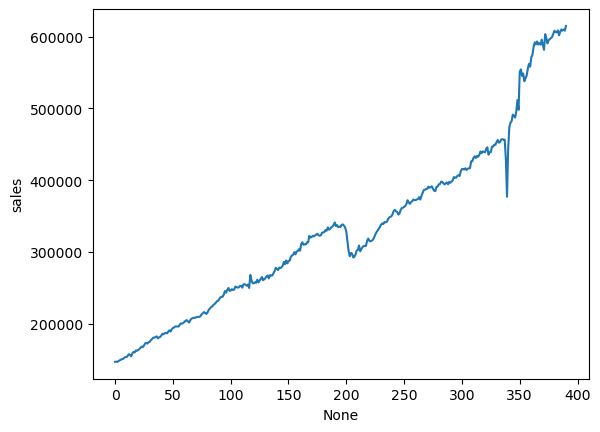

In [10]:
sns.lineplot(data = sales, x =sales.index, y = sales.sales)

In [14]:
def test_stationarity(dataFrame, var):
    dataFrame['rollMean'] = dataFrame[var].rolling(window=12).mean()
    dataFrame['rollStd'] = dataFrame[var].rolling(window=12).std()

    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(dataFrame[var], autolag = 'AIC')
    stats = pd.Series(adfTest[0:4], index = ['Test Statistic', 'p-value', '#lags', 'number of observations used']) 
    print(stats)

    for key, values in adfTest[4].items():
        print ('critical value', key, ":", values)

    sns.lineplot(data = sales, x= sales.index, y= sales.sales)
    sns.lineplot(data = sales, x= sales.index, y= sales.rollMean)
    sns.lineplot(data = sales, x= sales.index, y= sales.rollStd)

Test Statistic                   0.996649
p-value                          0.994230
#lags                           11.000000
number of observations used    379.000000
dtype: float64
critical value 1% : -3.4477224095888497
critical value 5% : -2.869196333125208
critical value 10% : -2.5708486586002604


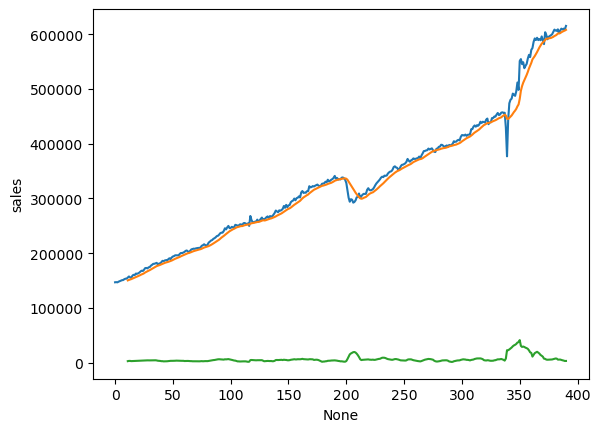

In [15]:
test_stationarity(sales, 'sales')

In [16]:
df = pd.merge(
    left = sales,
    right = persincome,
    on = 'DATE',
    how = 'outer'
)

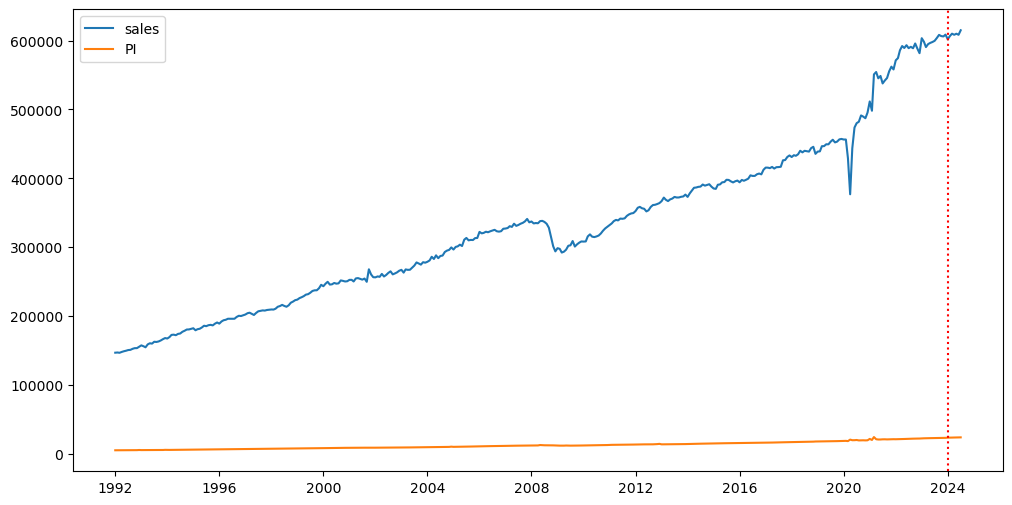

In [17]:
MAX_TRAINING_DATE = df.tail(7).iloc[0]['DATE']


plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['sales'], label='sales')
plt.plot(df['DATE'], df['PI'], label='PI')
plt.axvline(MAX_TRAINING_DATE, color='red', linestyle='dotted')
plt.legend()
plt.show()

df_train = df.loc[df['DATE'] < MAX_TRAINING_DATE, :]
df_test = df.loc[df['DATE'] >= MAX_TRAINING_DATE, :]

In [18]:
# Function to 'step' randomly in hyperparameter space
def step(params): 
    updated_params = copy.deepcopy(params)
    selected_variable = np.random.choice(['p', 'd', 'q', 'P', 'D', 'Q', 'a0', 'a1'], size=1)[0]
    current_value = updated_params[selected_variable]

    # Update the current value randomly
    updated_value = current_value + np.random.choice([-1, 1], size=1)[0]

    # Enforce parameter limits
    if(selected_variable in ['p', 'q']):
        low, high = 0, 6
    else:
        low, high = 0, 1
    
    updated_value = min([max([low, updated_value]), high])

    updated_params[selected_variable] = updated_value

    return updated_params

# Function to score hyperparameter set
def score(params, data):
    
    error_scores = []

    for validation_steps in [1,2,3,4,5]:
        training_set_length = data.shape[0] - validation_steps

        model = SARIMAX(
            endog = data['sales'].head(training_set_length), 
            exog = data['PI'].head(training_set_length), 
            order = (params['p'], params['d'], params['q']), # p, d, q order parameters for arima
            trend = [params['a0'], params['a1']], # A(t) = a0 + a1*t + a2*t^2 ... 
            seasonal_order = (params['P'], params['D'], params['Q'], 12) # P, D, Q seasonal order parameters
        ).fit()

        forecast = model.forecast(steps=validation_steps, exog=data['PI'].tail(validation_steps))
        actuals = data['sales'].tail(validation_steps)
        
        # compute error metric and return
        error = (forecast.tail(1) - actuals.tail(1)).abs().mean()
        error_scores.append(error)

    return np.mean(error_scores)

In [19]:
# Initial guess
x0 = {'p': 1, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 1}
f0 = score(x0, df_train)

# Keep track of best parameters
xbest = copy.deepcopy(x0)
fbest = f0

print('initial parameter score = ', f0)

initial parameter score =  2238.1506188844096


In [20]:
optimization_steps = 100

temperature = 0.05

optimization_progress = {'f0': [], 'fbest': []}

for t in range(optimization_steps):

    # Randomly changed x0
    x1 = step(x0)
    f1 = score(x1, df_train)

    # If the new point is lower in score than the previous (meaning better)
    if(f1 < f0):
        x0 = copy.deepcopy(x1)
        f0 = f1
    else: # if new point is worse, accept with some probability
        if(np.random.random() < 2**(-(f1-f0)/temperature)):
            x0 = copy.deepcopy(x1)
            f0 = f1

    # Update the 'best' parameters
    if(f0 < fbest):
        fbest = f0
        xbest = copy.deepcopy(x0)

    # Print out progress
    print('current score = {}, best score = {}'.format(f0, fbest))
    optimization_progress['f0'].append(f0)
    optimization_progress['fbest'].append(fbest)

current score = 2238.1506188844096, best score = 2238.1506188844096
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score =

C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adria\m

current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score =

C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adria\m

current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688


C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adria\m

current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score = 1636.2025526091688
current score = 1636.2025526091688, best score =

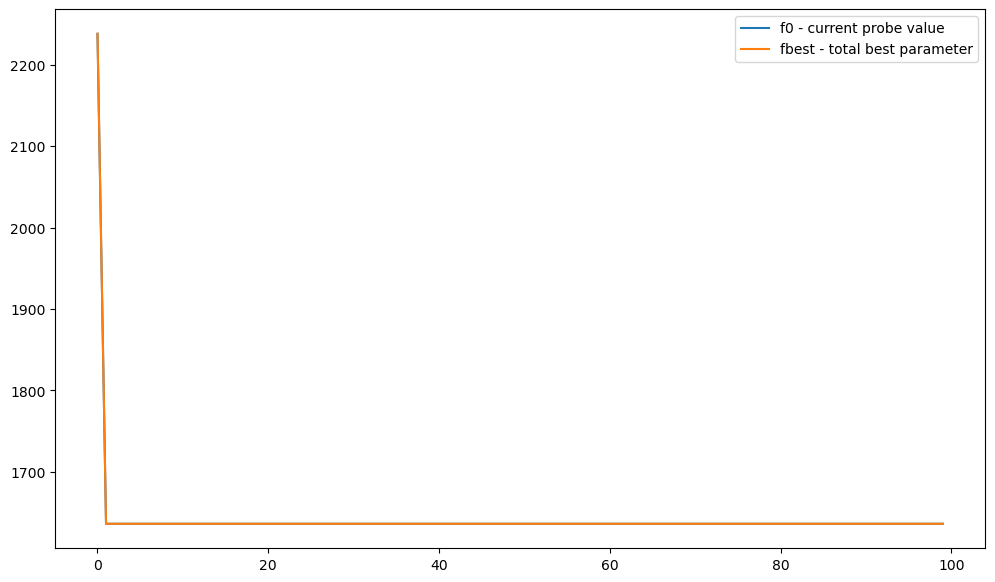

{'p': 1, 'd': 1, 'q': 1, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 1}


In [22]:
plt.figure(figsize = (12, 7))
plt.plot(optimization_progress['f0'], label = 'f0 - current probe value')
plt.plot(optimization_progress['fbest'], label = 'fbest - total best parameter')
plt.legend()
plt.show()
print(x0)

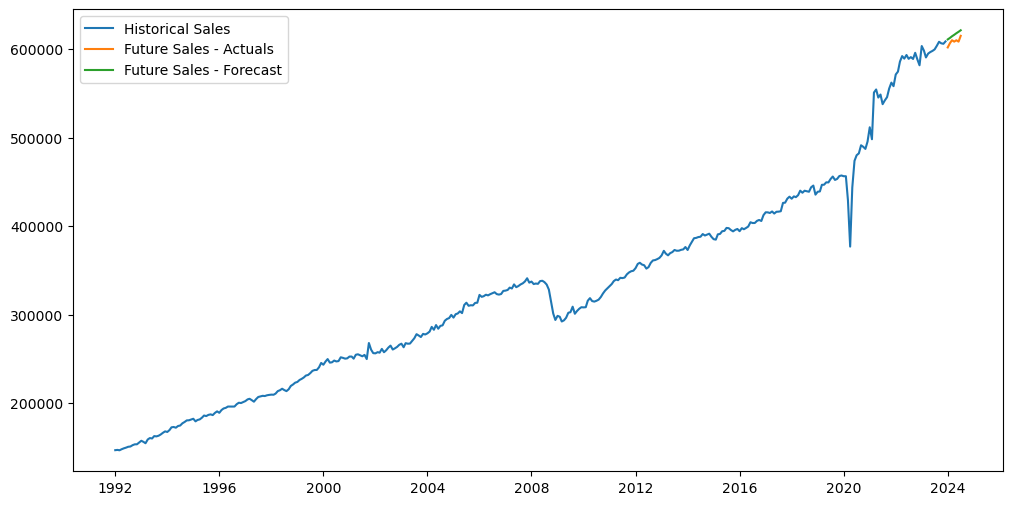

In [25]:
model = SARIMAX(
    endog = df_train['sales'], 
    exog = df_train['PI'], 
    order = (xbest['p'], xbest['d'], xbest['q']), # p, d, q order parameters for arima
    trend = [xbest['a0'], xbest['a1']], # A(t) = a0 + a1*t + a2*t^2 ... 
    seasonal_order = (xbest['P'], xbest['D'], xbest['Q'], 12) # P, D, Q seasonal order parameters
).fit()

forecast = model.forecast(steps=df_test.shape[0], exog=df_test['PI'])

plt.figure(figsize = (12, 6))
plt.plot(df_train['DATE'], df_train['sales'], label='Historical Sales')
plt.plot(df_test['DATE'], df_test['sales'], label='Future Sales - Actuals')
plt.plot(df_test['DATE'], forecast, label='Future Sales - Forecast')
plt.legend()
plt.show()